# Team Members:
- Amirhossein Mobayen

## Topic:
AI Chess Master

# Objective:
Build a Vision AI which understands a position by looking at the board!

In [1]:
import os

# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image, ImageOps
from sklearn.preprocessing import OneHotEncoder

from IPython.display import display

print(tf.config.list_physical_devices('GPU'))

2023-07-23 22:56:37.264504: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 22:56:37.281425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 22:56:37.373816: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 22:56:37.374675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 22:56:38.101319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

[]


2023-07-23 22:56:39.225828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 22:56:39.226322: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Step 1: Dataset Preparation


In [2]:
# Download the dataset from Kaggle and extract the relevant files.
# URL: https://www.kaggle.com/koryakinp/chess-positions

# Define the input image size for the model
img_height, img_width = 256, 256
batch_size = 32

# Define the path to the dataset directory
train_dir = './dataset/train/'
test_dir = './dataset/test/'

# Step 2: Data Preprocessing

In [3]:
def crop_image(img):
    rows, columns = 8, 8
    # Calculate the width and height of each cropped region
    crop_width = img_width // columns
    crop_height = img_height // rows

    # Use list comprehension to crop the image and store the cropped regions in a list
    return [img.crop((col * crop_width, row * crop_height, (col + 1) * crop_width, (row + 1) * crop_height))
            for row in range(rows) for col in range(columns)]


def flatten_comprehension(matrix):
    return np.array([item for row in matrix for item in row])


def create_chessboard(fen_position):
    # Initialize an empty 8x8 chessboard (2D list)
    chessboard = [["." for _ in range(8)] for _ in range(8)]

    # Translate the FEN string to the chessboard list
    rank, file = 7, 0  # Start from the top-left corner (a8)
    for char in fen_position:
        if char == '-':  # Move to the next rank (row)
            rank -= 1
            file = 0
        elif char.isdigit():  # Empty squares
            file += int(char)
        elif char.isupper():  # White pieces
            chessboard[rank][file] = char
            file += 1
        elif char.islower():  # Black pieces
            chessboard[rank][file] = char
            file += 1

    return chessboard

In [5]:
cells = []
labels = []
# Iterate over the files in the directory
for filename in os.listdir(train_dir):
    # Check if the file has a valid image extension
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # Open the image and convert it to grayscale
        img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(train_dir, filename)))

        # Resize the image to the desired width and height
        img_resized = img_gray_scale.resize((img_width, img_height), Image.Resampling.LANCZOS)
        cells.append(crop_image(img_resized))
        labels.append(flatten_comprehension(create_chessboard(filename[:-5])))

train_set = np.array(flatten_comprehension(cells))
train_label_set = np.array(flatten_comprehension(labels)).reshape(-1, 1)

In [4]:
cells = []
labels = []
# Iterate over the files in the directory
for filename in os.listdir(test_dir):
    # Check if the file has a valid image extension
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # Open the image and convert it to grayscale
        img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(test_dir, filename)))

        # Resize the image to the desired width and height
        img_resized = img_gray_scale.resize((img_width, img_height), Image.Resampling.LANCZOS)
        cells.append(crop_image(img_resized))
        labels.append(flatten_comprehension(create_chessboard(filename[:-5])))

test_set = flatten_comprehension(cells)
test_label_set = flatten_comprehension(labels).reshape(-1, 1)

In [6]:
train_X = train_set / 255.0
test_X = test_set / 255.0

encoder = OneHotEncoder()
train_y = encoder.fit_transform(train_label_set.reshape(-1, 1)).toarray()
test_y = encoder.transform(test_label_set.reshape(-1, 1)).toarray()

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(512000, 32, 32) (512000, 13) (128000, 32, 32) (128000, 13)


# Step 3: Model Selection and Architecture

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 32)                230432    
                                                                 
 dense_1 (Dense)             (None, 13)                429       
                                                                 
Total params: 231,181
Trainable params: 231,181
Non-trainable params: 0
__________________________________________________

# Step 4: Model Training

In [10]:
# Clear any previous TensorFlow session
tf.keras.backend.clear_session()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

history = model.fit(train_X, train_y,
                    batch_size=64,
                    epochs=10,
                    validation_data=[test_X, test_y],
                    callbacks=[early])


Epoch 1/10
8000/8000 [==============================] - 55s 7ms/step - loss: 0.8737 - accuracy: 0.8276 - val_loss: 0.8822 - val_accuracy: 0.8260
Epoch 2/10
8000/8000 [==============================] - 55s 7ms/step - loss: 0.8733 - accuracy: 0.8276 - val_loss: 0.8850 - val_accuracy: 0.8260
Epoch 3/10
8000/8000 [==============================] - 55s 7ms/step - loss: 0.8731 - accuracy: 0.8276 - val_loss: 0.8807 - val_accuracy: 0.8260
Epoch 4/10
8000/8000 [==============================] - 55s 7ms/step - loss: 0.8728 - accuracy: 0.8276 - val_loss: 0.8808 - val_accuracy: 0.8260
Epoch 5/10
8000/8000 [==============================] - 55s 7ms/step - loss: 0.8726 - accuracy: 0.8276 - val_loss: 0.8817 - val_accuracy: 0.8260
Epoch 6/10
8000/8000 [==============================] - 54s 7ms/step - loss: 0.8723 - accuracy: 0.8276 - val_loss: 0.8824 - val_accuracy: 0.8260
Epoch 7/10
8000/8000 [==============================] - 54s 7ms/step - loss: 0.8722 - accuracy: 0.8276 - val_loss: 0.8812 - val_ac

# Step 5: Model Evaluation

In [11]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_X, test_y)

4000/4000 [==============================] - 4s 1ms/step - loss: 0.8808 - accuracy: 0.8260


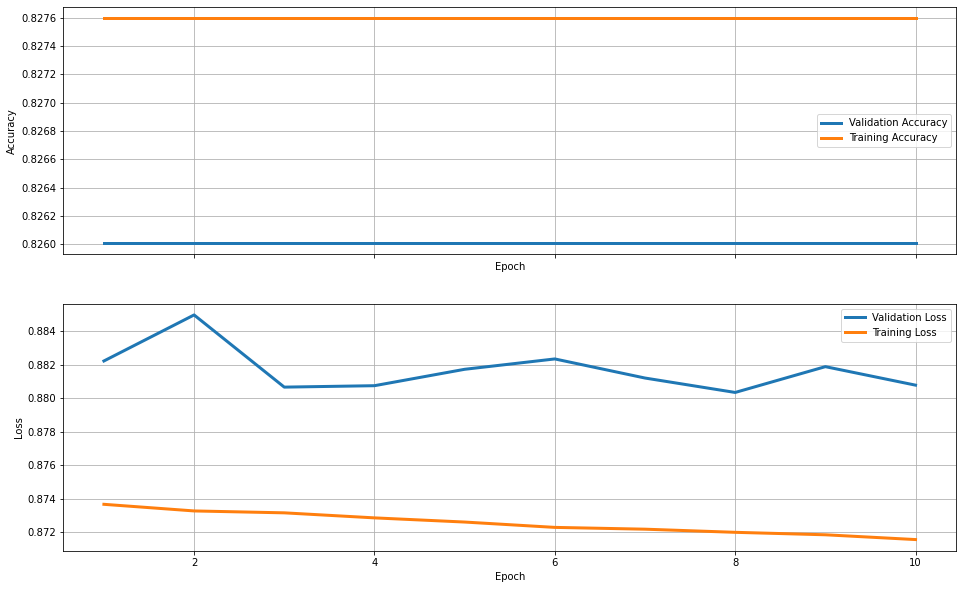

In [12]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns = ["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df) + 1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()


plot_results(history)

# Step 6: Model Deployment

In [0]:
# Save the trained model weights for future use
model.save('chessboard_model.h5')

In [7]:

# Load the saved model
loaded_model = tf.keras.models.load_model('chessboard_model.h5')

# Sample Test

In [26]:
# Iterate over a few samples from the validation dataset
for idx in range(64):
    # Take a single test image from the test set
    test_image = test_X[idx]

    # Make predictions on the single image
    predictions = loaded_model.predict(test_image.reshape(1, 32, 32, 1))
    predicted_labels = encoder.inverse_transform(predictions)

    print('predicted value:', predicted_labels)
    print('true Value:', test_label_set[idx])
    print('---')


1/1 [==============================] - 0s 12ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 12ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 12ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 12ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 11ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 11ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 12ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 15ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [==============================] - 0s 11ms/step
predicted value: [['.']]
true Value: ['B']
---
1/1 [==============================] - 0s 12ms/step
predicted value: [['.']]
true Value: ['.']
---
1/1 [=====